На семинаре мы рассматривали постановку OCO (Online Convex Optimization) применительно к онлайн выбору портфеля акций. Мы рассмотрели простой алгоритм Follow The **Linearized** Leader + два алгоритма в стратегии Follow The **Regularized** Leader:  [Exponentiated Gradient](http://www.rob.schapire.net/papers/HelmboldScSiWa98.pdf) и  [AdaHedge](https://arxiv.org/pdf/1912.13213) (7.6), в которых в качестве регуляризатора выступала **энтропия Шеннона** : $R(x) = \sum_{j=1}^{n} x_j log(x_j)$


Но могут быть и другие регуляризаторы, которые порождают другие алгоритмы. Например, **log-barier**: $R(x) = \sum_{j=1}^{n} log(<x, e_j>)$, где $(e_i)_{i=1}^n$ - базис. И задача принимает вид: $$x_t = argmax _{x\in \Delta_n} \sum_{t+1}^{t-1} log(<r_t, x>) + \sum_{j=1}^{n} log(<x, e_j>)$$

Если выбор портфеля происходит по формуле выше, то такая стратегия назвается **Smooth Selection**.

Но если в лоб решать эту задачу (назовем алгоритм **ss**), то регрет будет содержать в себе $r$, где $r$ нижняя граница всех регретов, т.е мы подразумеваем, что:
$1\geq r_t[i]\geq r > 0$.

Чтобы оценка регрета не содержала $r$ можно предложить модификацию алгоритма (назовем  **modified_ss**) с заменой, как в семинаре:
$$\tilde{r}_t ← (1-\frac{\alpha}{n})r_t + \frac{\alpha}{n} 1$$

$$\tilde{x}_t = (1-\alpha)x_t + \frac{\alpha}{n}$$

Cобственно, эти два алгоритма (ss + modified_ss) нужно реализвовать, и проверить их работу на синтетических и реальных ланный с yahoo. Части, которые повторяются с семинара уже используются, но в ноутбук семинара полезно заглянуть, чтобы понять как реализвать функции.

In [3]:
import cvxpy as cp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install yfinance
import yfinance as yf
import pandas as pd
import string
import random

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16, 8)

In [4]:
"""выбрать лучший портфель в терминах OCO 'заглядывая в будущее'

   с семинара - здесь ничего менять не нужно
"""
def Best_Constantly_Rebalanced_Portfolio(r):
	T = r.shape[0]
	n = r.shape[1]
	if T==0:
		return np.ones(n)/n

	x = cp.Variable(n)

	obj = cp.sum(cp.log(r@x))
	prob = cp.Problem(cp.Maximize(obj), [cp.sum(x) == 1, x >= 0])
	prob.solve()
	return x.value

$$x_t = argmax _{x\in \Delta_n} \sum_{t+1}^{t-1} log(<r_t, x>) + \sum_{j=1}^{n} log(<x, e_j>)$$

Smooth_Selection выдает вектор решений на каждом шаге, можете написать либо свою функцию. Либо интереснее подумать, как можно написать с помощью ранее определенной Best_Constantly_Rebalanced_Portfolio

In [5]:
# Smooth_Selection на вход принимает r - вектор регретов, выдает вектор портфеля x до рассматриваемого шага t
# можно и нужно использовать ранее определенную Best_Constantly_Rebalanced_Portfolio (посмотри в семинаре)

def Smooth_Selection(r):
    T = r.shape[0]
    n = r.shape[1]
    if T == 0:
        return np.ones(n)/n
    
    modified_returns = np.vstack([r, np.eye(n)])
    x = Best_Constantly_Rebalanced_Portfolio(modified_returns)
    
    return x

с модификацией мы длолжны решать задачу:
$$x_t = argmax _{x\in \Delta_n} \sum_{t+1}^{t-1} log(<\tilde{r}_t, x>) + \varepsilon * \sum_{j=1}^{n} log(<\tilde{x}, e_j>)$$, подставляя:

$$\tilde{r}_t ← (1-\frac{\alpha}{n})r_t + \frac{\alpha}{n} 1$$

$$\tilde{x}_t = (1-\alpha)x_t + \frac{\alpha}{n}$$

$$\varepsilon =  \frac{1}{r_{min}}$$
$$\alpha =  n \sqrt{\frac{\log T}{T}}$$


In [6]:
def Modified_Smooth_Selection(r, alpha=0.1):
	T = r.shape[0]
	n = r.shape[1]
	if T == 0:
		return np.ones(n)/n

	# Модифицируем доходности
	r_tilde = (1 - alpha/n) * r + alpha/n
	x_tilde = Smooth_Selection(r_tilde)

	# Модифицируем портфель
	x = (1 - alpha) * x_tilde + alpha/n

	return x

ПРОВЕРКА РАБОТЫ НА СИНТЕТИКЕ

In [7]:
random.seed(444)
np.random.seed(444)
# число стоков(акций)
n = 5
# генерим названия стоков
dummy_stocks = [''.join(random.choices(string.ascii_uppercase, k=5)) for i in range(n)]
# рассматриваемый период
T = 700

#Log-normal returns
r = np.exp(np.random.normal(0, 0.03, size=(T,n)))
df = pd.DataFrame(data = r.cumprod(axis=0), columns = dummy_stocks)

<Axes: >

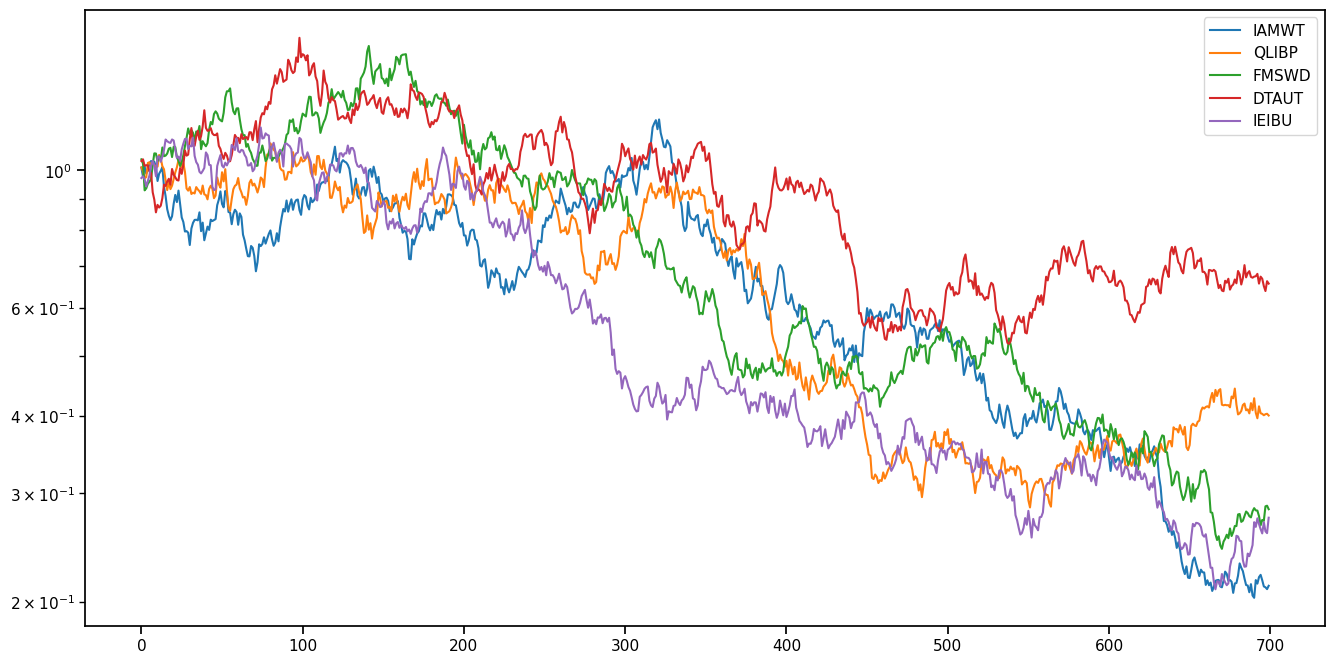

In [8]:
df.plot(logy=True)

<Axes: >

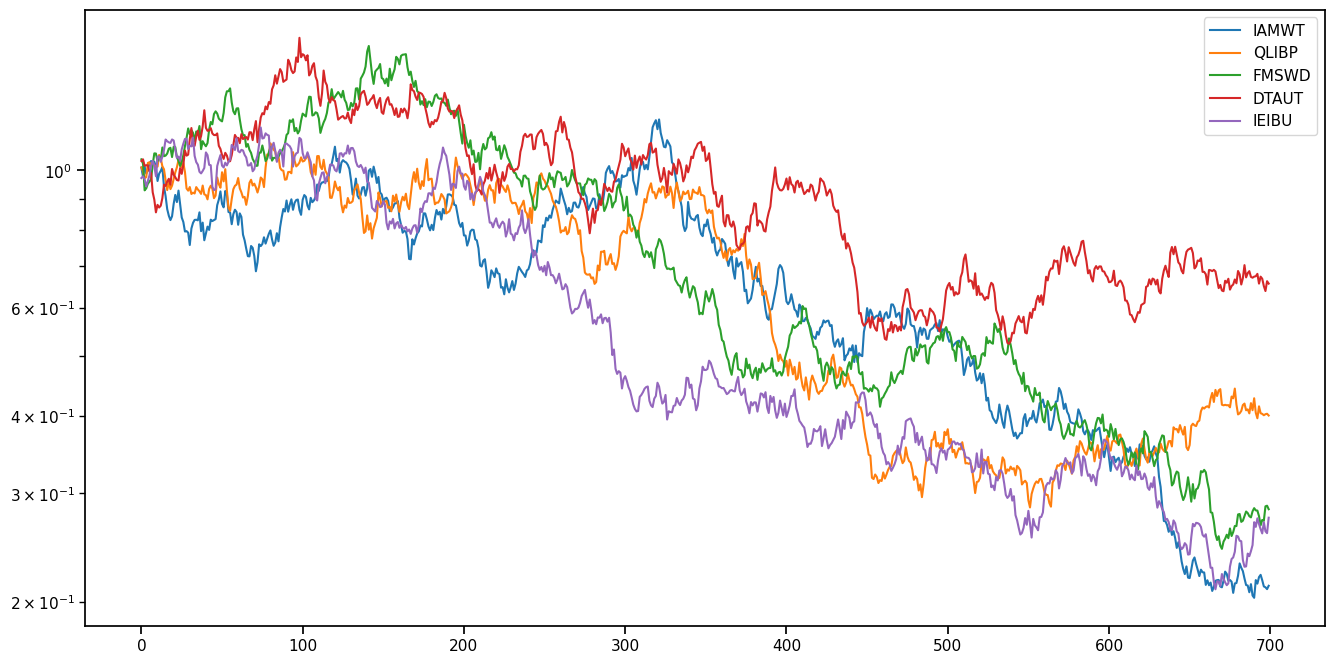

In [9]:
df.plot(logy=True)

In [10]:
ss = Smooth_Selection(r)
df["SS"] = np.cumprod(np.sum(r*ss, axis=1))

mss = Modified_Smooth_Selection(r)
df["MSS"] = np.cumprod(np.sum(r*mss, axis=1))

bcrp = Best_Constantly_Rebalanced_Portfolio(r)
df['BCRP']= np.cumprod(r@bcrp)

<Axes: >

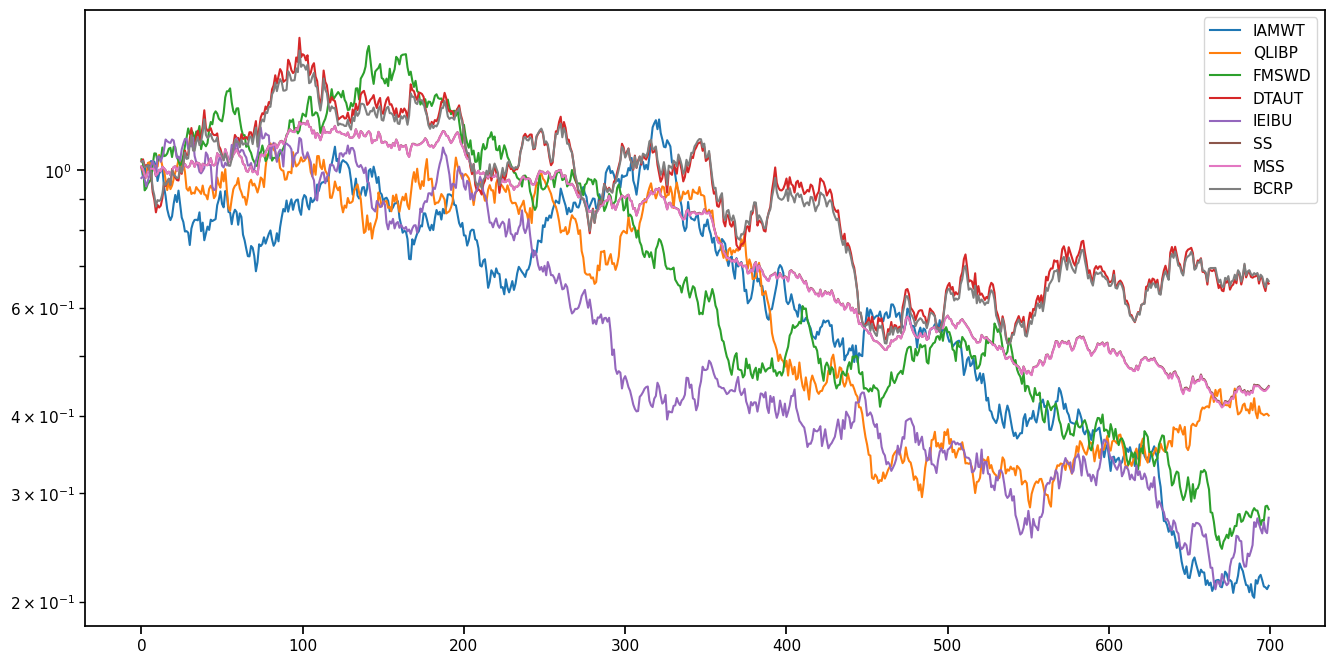

In [11]:
df.plot(logy=True)

<Axes: >

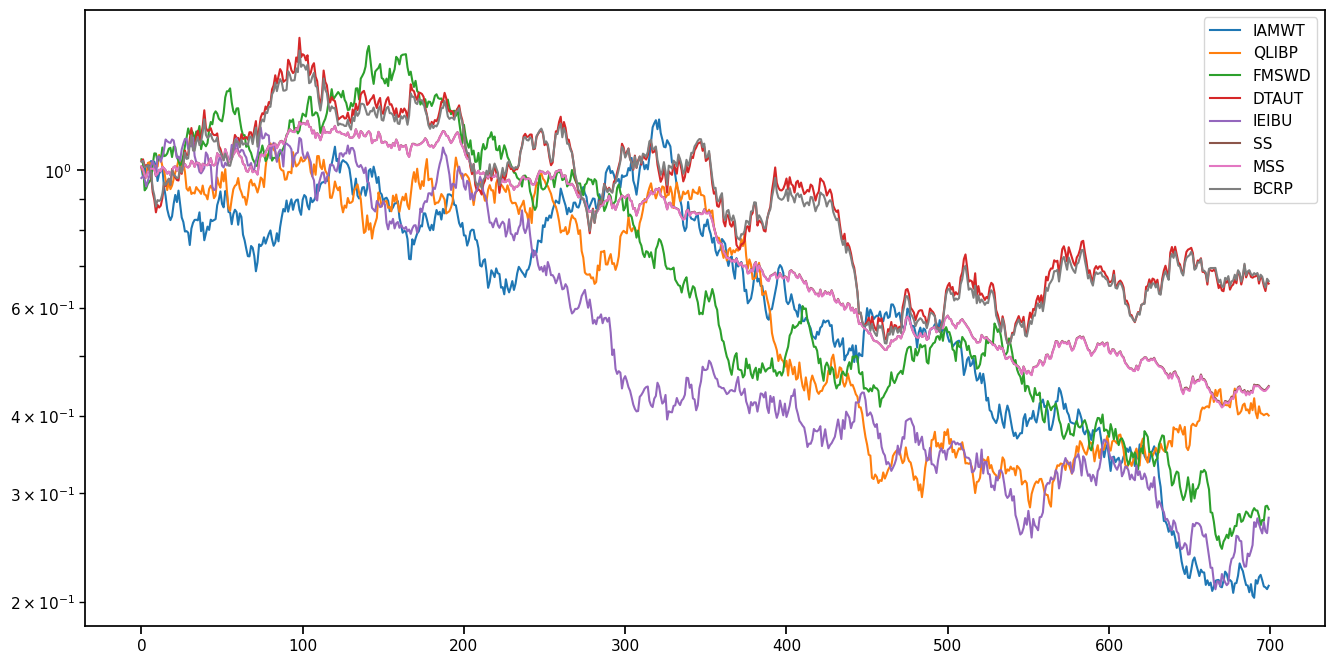

In [12]:
#cмотрим как ведут себя стратегии smooth и modified smooth по отношению к траекториям отдельных акций
df.plot(logy=True)

<Axes: >

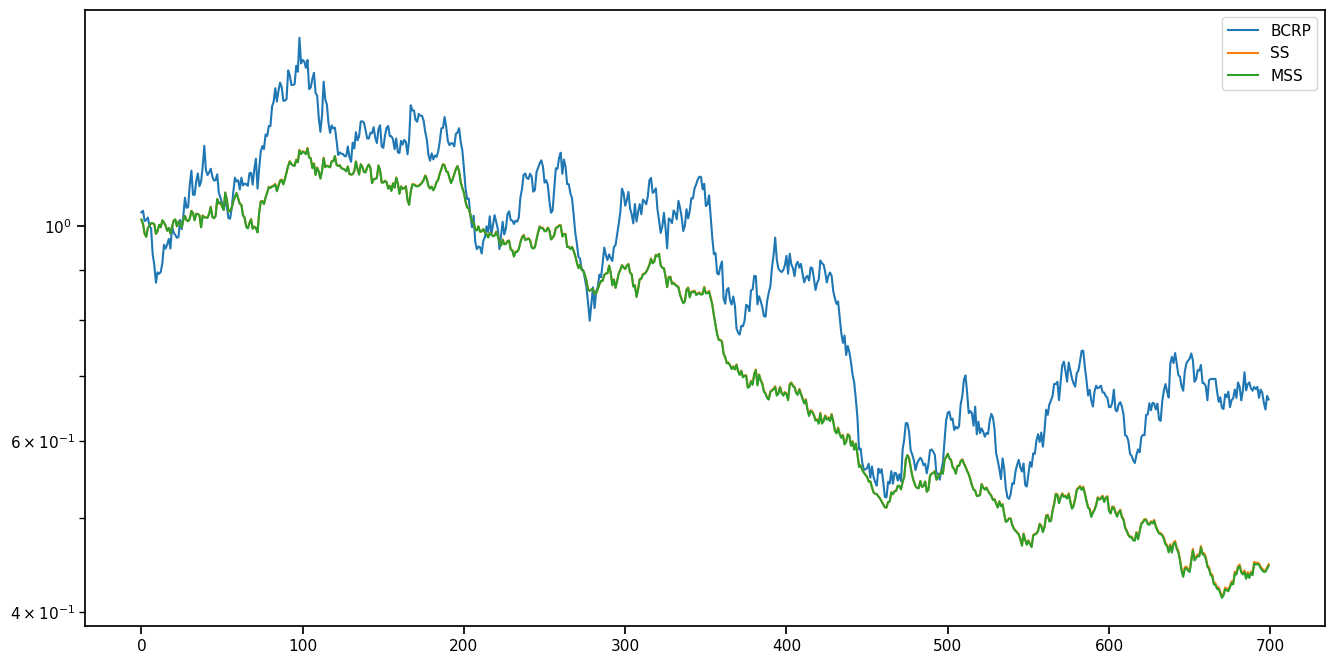

In [13]:
df[["BCRP", "SS", "MSS"]].plot(logy=True)

<Axes: >

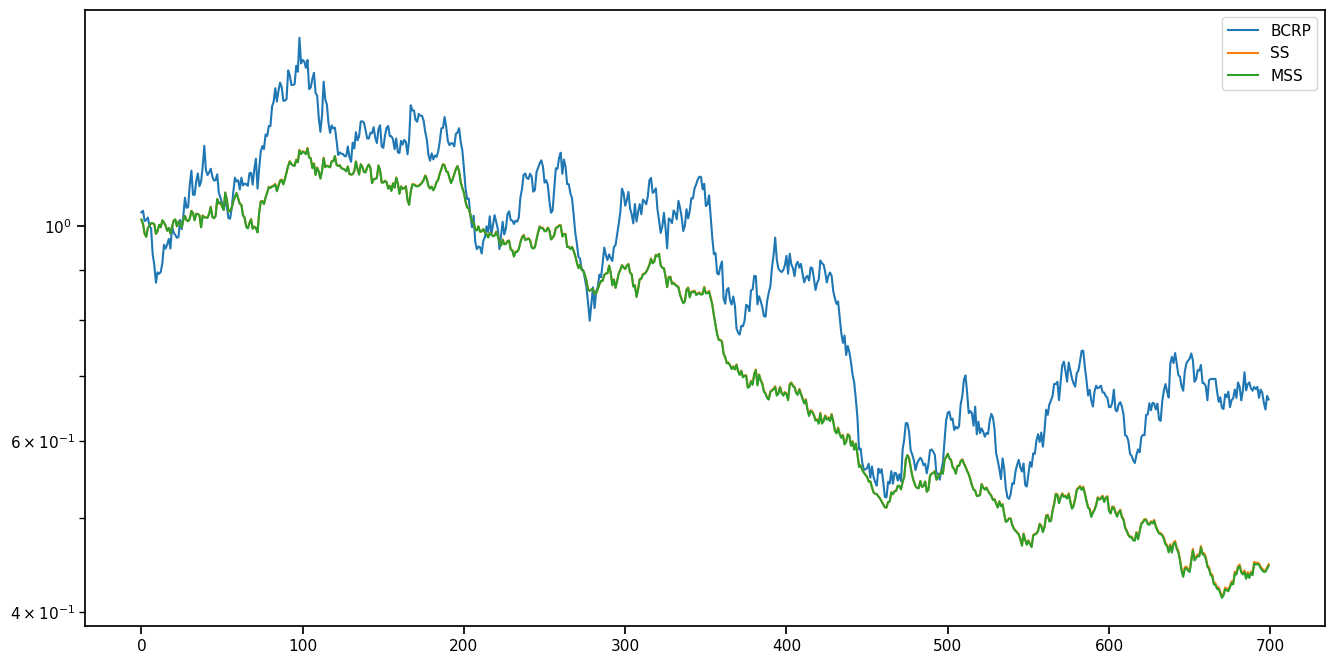

In [14]:
#cмотрим как ведут себя стратегии smooth и modified smooth по отношению к лучшей (в терминах OCO) стратегии
df[["BCRP", "SS", "MSS"]].plot(logy=True)

ПРОВЕРКА РАБОТЫ НА РЕАЛЬНЫХ ДАННЫХ

In [15]:
# выбор рассматриваемого периода
start = '2023-04-10'
end = '2025-04-10'

# выбор стоков
assets = [ 'JPM', 'NFLX', 'XOM', 'VZ', 'META']
assets.sort()
n = len(assets)


# загрузка данных
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Close', slice(None))]
data.columns = assets

# вычислениу r

df = 1+data[assets].pct_change().dropna()/100
r = df.to_numpy()
df = df.cumprod(axis=0)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


<Axes: xlabel='Date'>

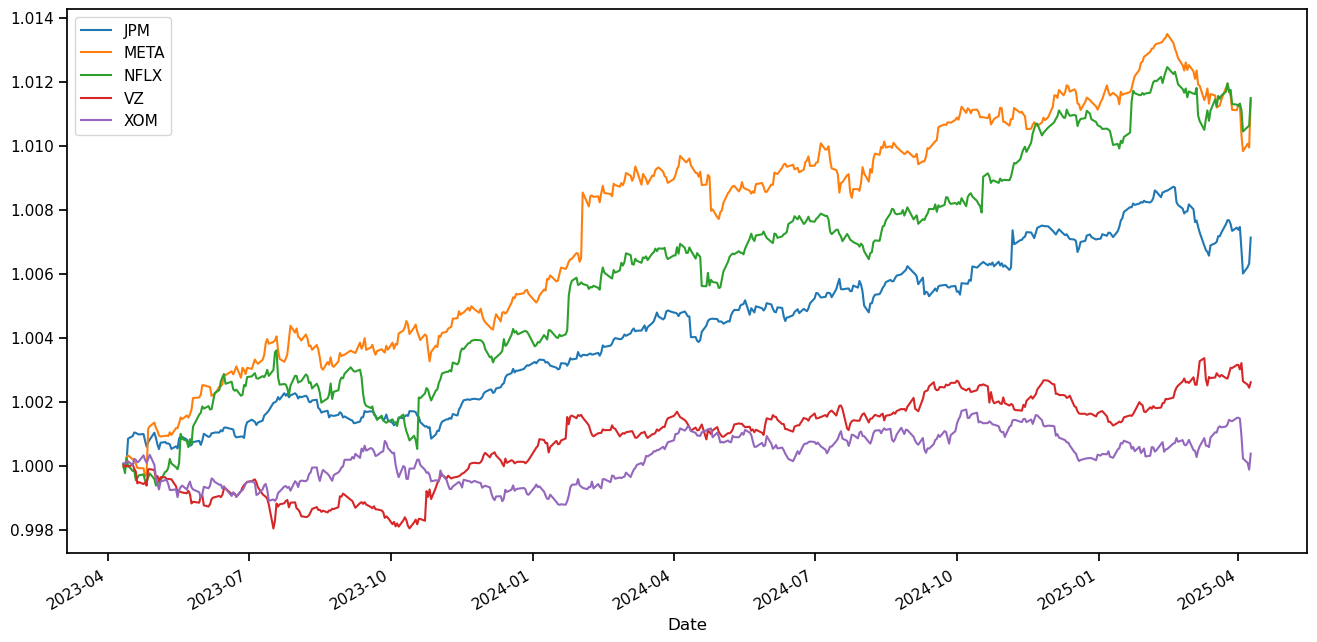

In [16]:
df.plot()

<Axes: xlabel='Date'>

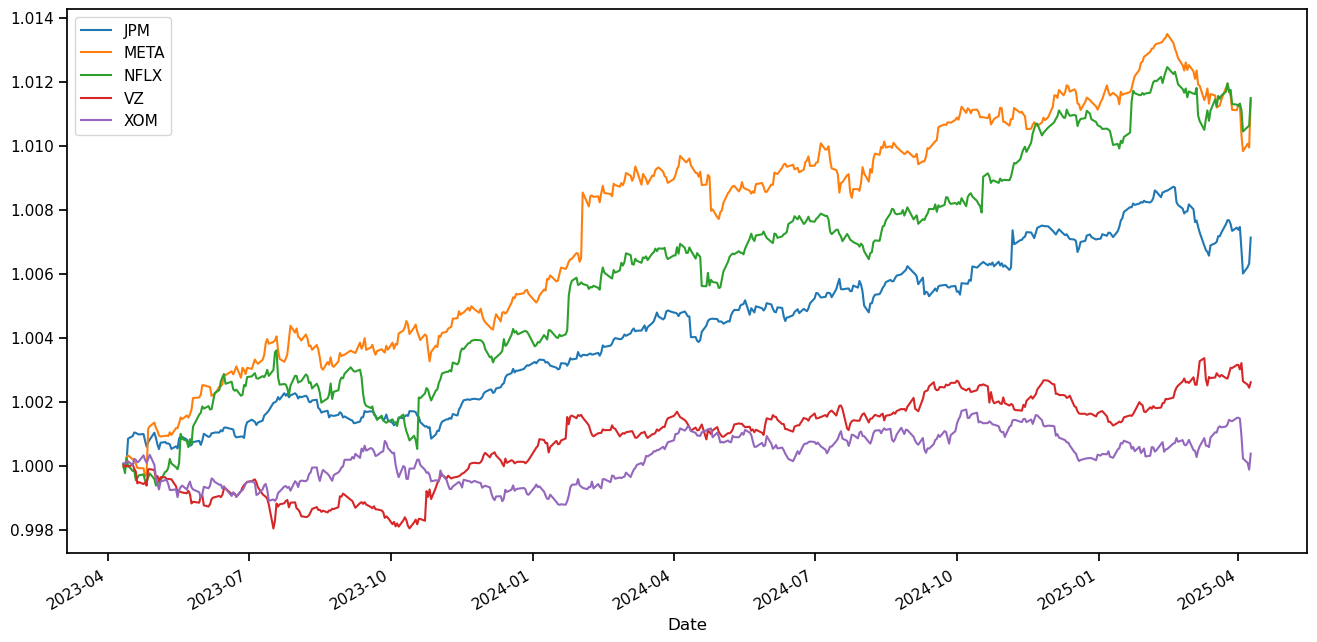

In [17]:
#cмотрим на траектории отдельных акций
df.plot()

In [18]:
ss = Smooth_Selection(r)
df["SS"] = np.cumprod(np.sum(r*ss, axis=1))

mss = Modified_Smooth_Selection(r)
df["ModifiedSS"] = np.cumprod(np.sum(r*mss, axis=1))

<Axes: xlabel='Date'>

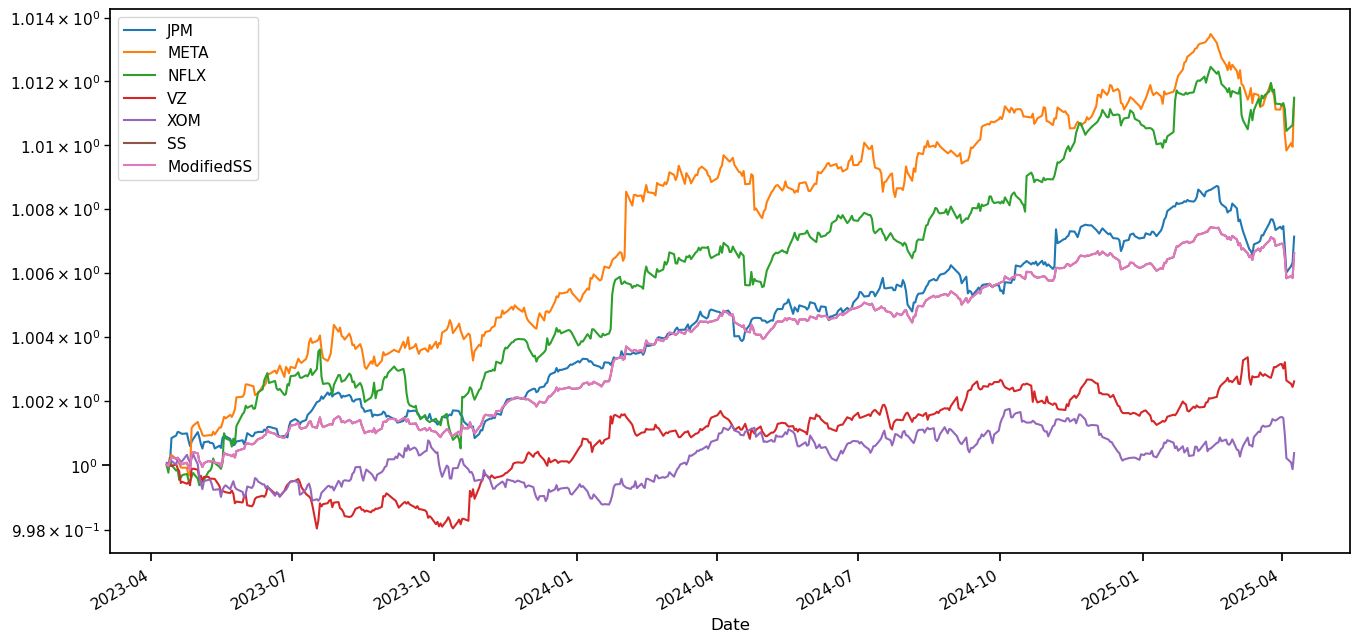

In [19]:
df.plot(logy=True)

<Axes: xlabel='Date'>

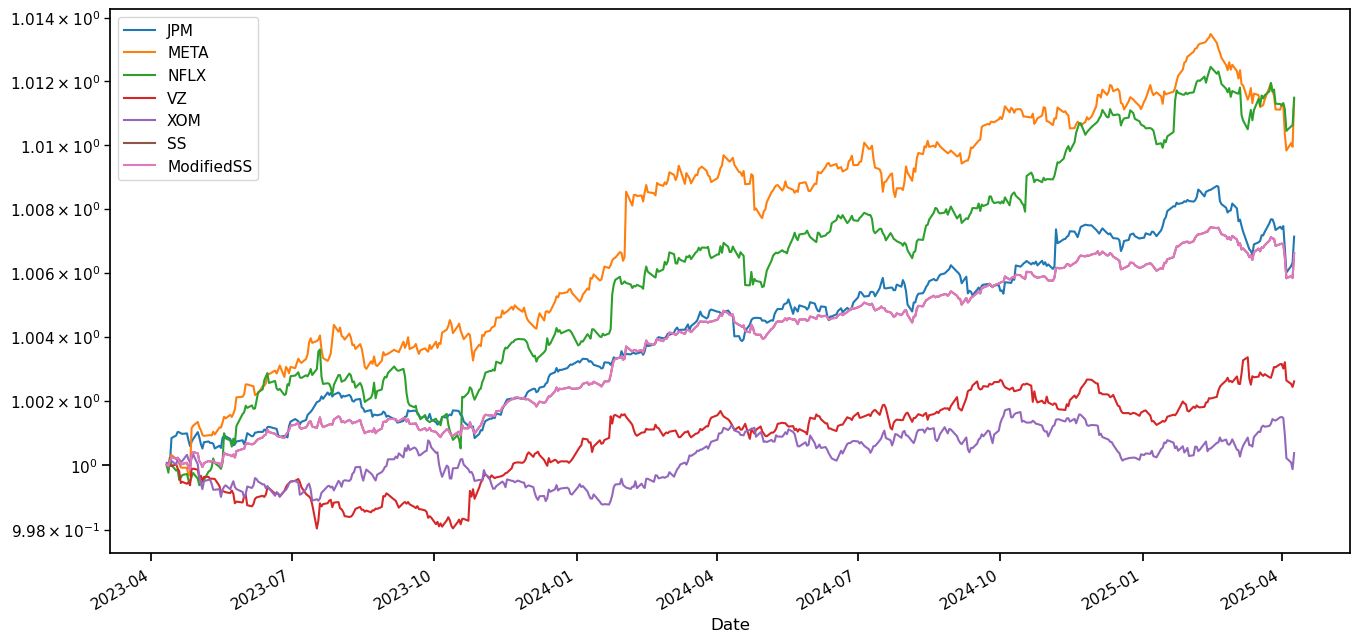

In [20]:
#cмотрим как ведут себя стратегии smooth и modified smooth по отношению к траекториям отдельных акций
df.plot(logy=True)

<Axes: xlabel='Date'>

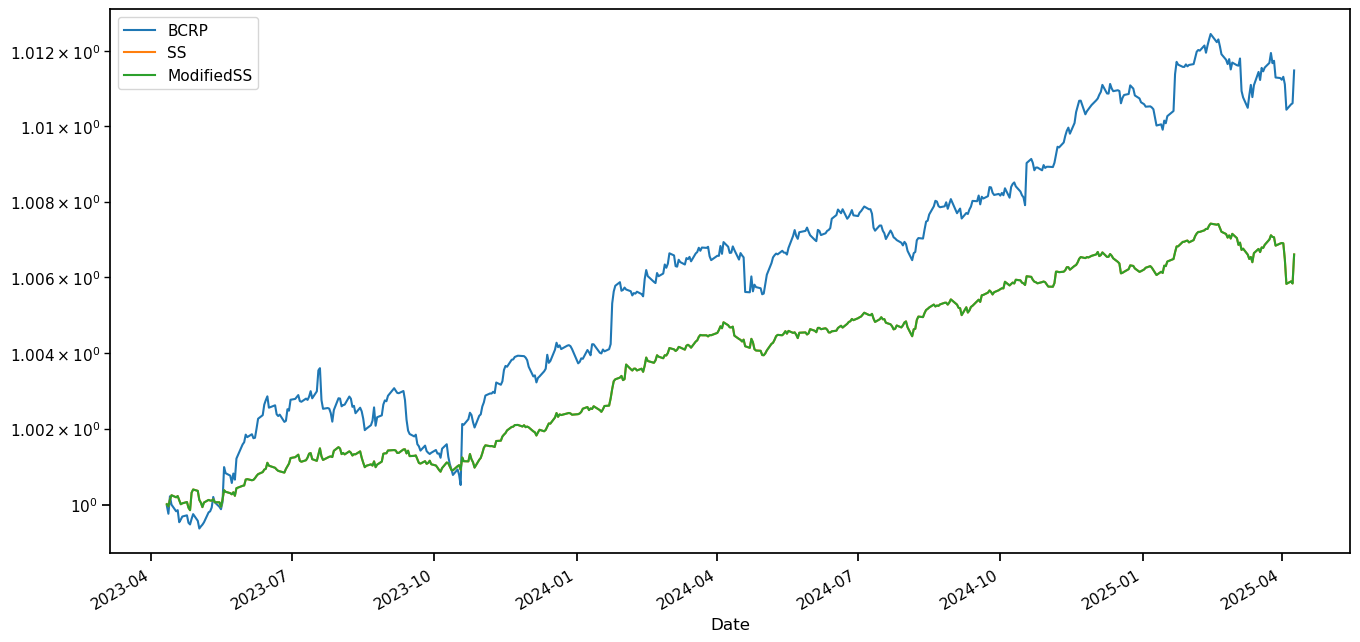

In [21]:
bcrp = Best_Constantly_Rebalanced_Portfolio(r)
df['BCRP']= np.cumprod(r@bcrp)

df[["BCRP", "SS", "ModifiedSS"]].plot(logy=True)

<Axes: xlabel='Date'>

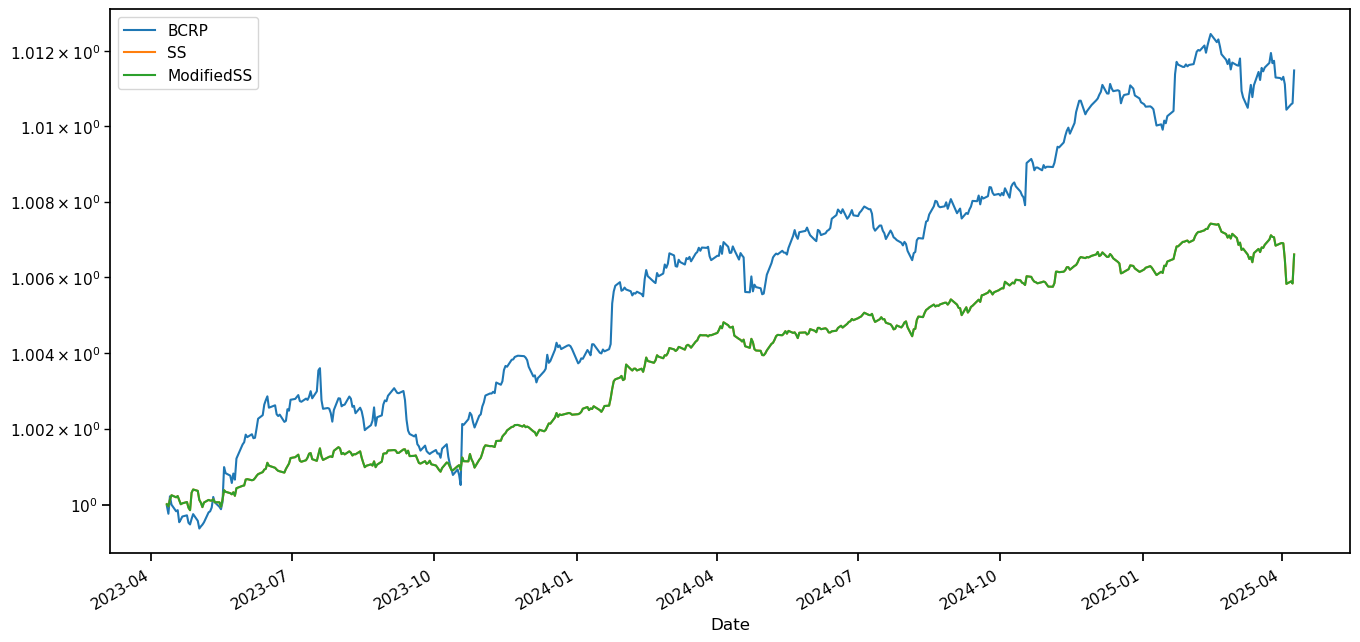

In [22]:
#cмотрим как ведут себя стратегии smooth и modified smooth по отношению к лучшей (в терминах OCO) стратегии

bcrp = Best_Constantly_Rebalanced_Portfolio(r)
df['BCRP']= np.cumprod(r@bcrp)

df[["BCRP", "SS", "ModifiedSS"]].plot(logy=True)

-------------------------------

В семинаре, в стратегии Linearized Follow-The--Leader, мы использовали линейную аппроксимацию:
**Linearizing** $$f_t(x) \sim f_t(x_t) + \nabla f_t(x_t)^T(x-x_t)$$

**А что если рассмотрим точность до второго порядка? -> т.е метод Ньютона.**
$$f_t(x) \sim f_t(x_t) + \nabla f_t(x_t)^T(x-x_t) + \frac{1}{2} (x-x_t)^TA_t(x_t)(x-x_t)$$

Здесь: $$A_t(x) = \frac{r_r r_t^T}{r_t^T x}$$
**Ну и выбор портфеля делаем:** $$x_{t+1} = argmin_{x\in \Delta_n} \sum_{t=1}^t f_t(x)$$

Тогда стратегия называется **Quadratized Follow-The-Leader**

Ну еще регуляризатор добавим: $$x_{t+1} = argmin_{x\in \Delta_n} \sum_{t=1}^t f_t(x) + \varepsilon R(x)$$ и получим **Quadratized Follow-The-Regularized-Leader**)).

 Здесь $\varepsilon$, чтобы общий случай рассмотреть: 0, если не учитываем регуляризатор и, например, 1, если учитываем.

Рассмотрим **регуляризатор** для квадратичных функций: $R(x) = \frac{1}{2} ||x||_2^2$








In [ ]:
from scipy.optimize import minimize
import numpy as np

def Quadratized_Follow_The_Regularized_Leader(r, epsilon):
    T = r.shape[0]
    n = r.shape[1]
    if T == 0:
        return np.ones(n)/n
    
    x_history = [np.ones(n)/n]
    
    for t in range(1, T):
        sum_grad = np.zeros(n)
        sum_hessian = np.zeros((n, n))
        
        for i in range(t):
            r_i = r[i]
            x_i = x_history[i]
            denom = x_i @ r_i
            
            # Градиент
            sum_grad += -r_i / denom
            
            # Гессиан
            A = np.outer(r_i, r_i) / (denom ** 2)
            sum_hessian += A
        
        # Добавляем регуляризатор
        sum_grad += epsilon * x_history[-1]
        sum_hessian += epsilon * np.eye(n)
        
        def objective(x):
            return sum_grad @ x + 0.5 * x @ sum_hessian @ x
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = [(0, 1) for _ in range(n)]
        
        x0 = x_history[-1].copy()
        
        res = minimize(
            objective,
            x0=x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )
        
        x_new = res.x
        x_new = np.clip(x_new, 0, None)
        x_new /= x_new.sum()
        x_history.append(x_new)
    
    return np.array(x_history)

In [26]:
qftl = Quadratized_Follow_The_Regularized_Leader(r, epsilon=0)
df["QFTL"] = np.cumprod(np.sum(r*qftl, axis=1))

qftrl = Quadratized_Follow_The_Regularized_Leader(r, epsilon=1)
df["QFTRL"] = np.cumprod(np.sum(r*qftrl, axis=1))

ss = Smooth_Selection(r)
df["SS"] = np.cumprod(np.sum(r*ss, axis=1))

mss = Modified_Smooth_Selection(r)
df["ModifiedSS"] = np.cumprod(np.sum(r*mss, axis=1))

bcrp = Best_Constantly_Rebalanced_Portfolio(r)
df['BCRP']= np.cumprod(r@bcrp)

<Axes: xlabel='Date'>

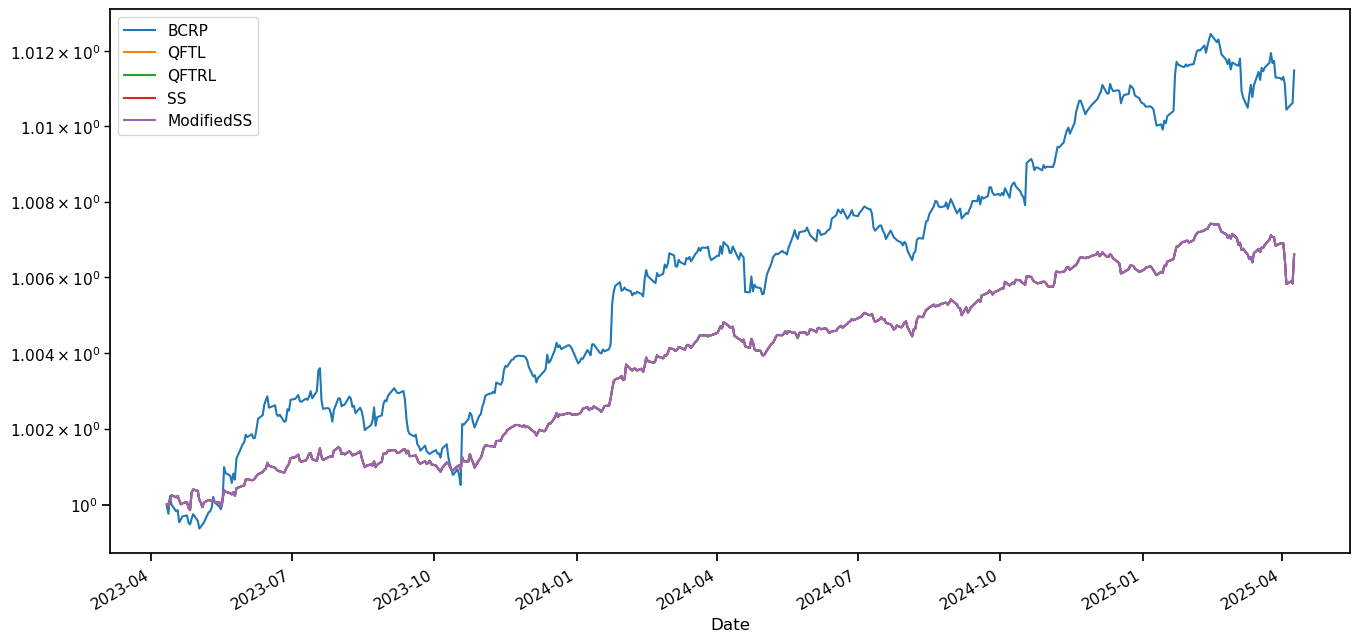

In [27]:
#cмотрим как ведут себя стратегии smooth, modified smooth, ftql на реальных данных  по отношению к лучшей (в терминах OCO) стратегии

df[["BCRP", "QFTL", "QFTRL","SS", "ModifiedSS"]].plot(logy=True)

<Axes: xlabel='Date'>

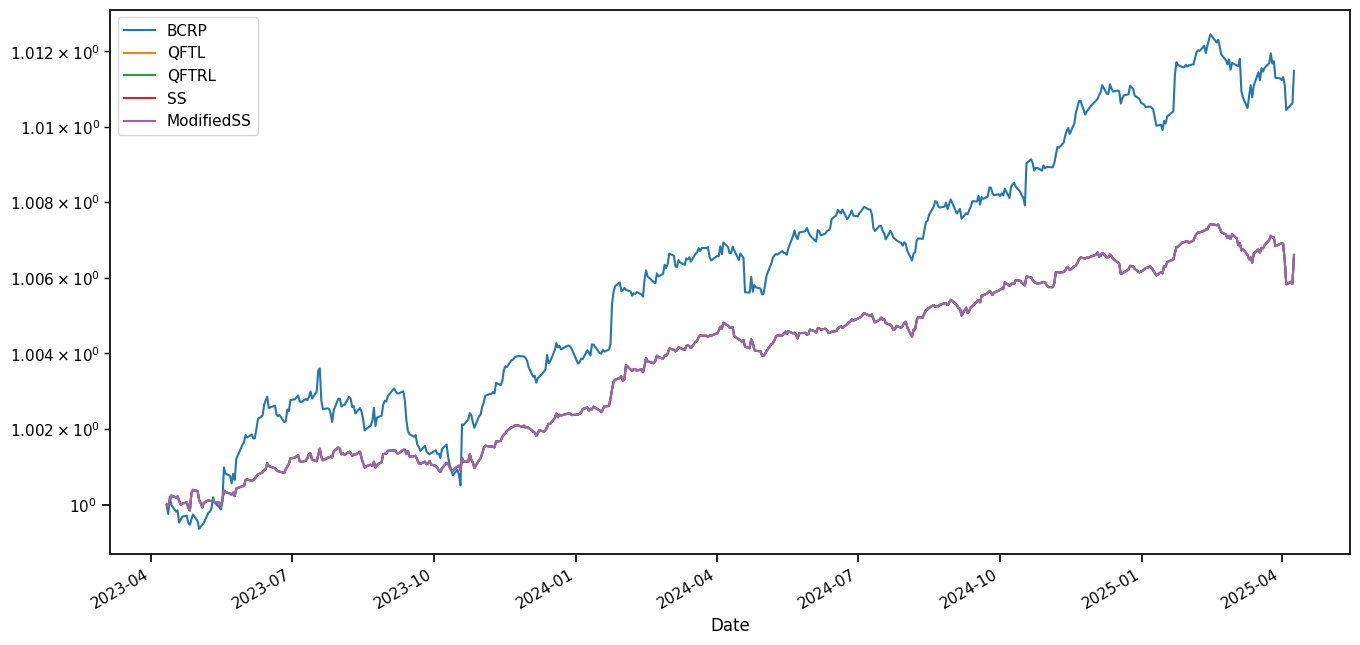

In [ ]:
#cмотрим как ведут себя стратегии smooth, modified smooth, ftql на реальных данных  по отношению к лучшей (в терминах OCO) стратегии

df[["BCRP", "QFTL", "QFTRL","SS", "ModifiedSS"]].plot(logy=True)

НА СИНТЕТИКЕ

In [28]:
random.seed(444)
np.random.seed(444)
# число стоков(акций)
n = 5
# генерим названия стоков
dummy_stocks = [''.join(random.choices(string.ascii_uppercase, k=5)) for i in range(n)]
# рассматриваемый период
T = 700

#Log-normal returns
r = np.exp(np.random.normal(0, 0.03, size=(T,n)))
df = pd.DataFrame(data = r.cumprod(axis=0), columns = dummy_stocks)

In [29]:
ss = Smooth_Selection(r)
df["SS"] = np.cumprod(np.sum(r*ss, axis=1))

mss = Modified_Smooth_Selection(r)
df["ModifiedSS"] = np.cumprod(np.sum(r*mss, axis=1))

bcrp = Best_Constantly_Rebalanced_Portfolio(r)
df["BCRP"]= np.cumprod(r@bcrp)

qftl = Quadratized_Follow_The_Regularized_Leader(r, epsilon=0)
df["QFTL"] = np.cumprod(np.sum(r*qftl, axis=1))

qftrl = Quadratized_Follow_The_Regularized_Leader(r, epsilon=1)
df["QFTRL"] = np.cumprod(np.sum(r*qftrl, axis=1))


<Axes: >

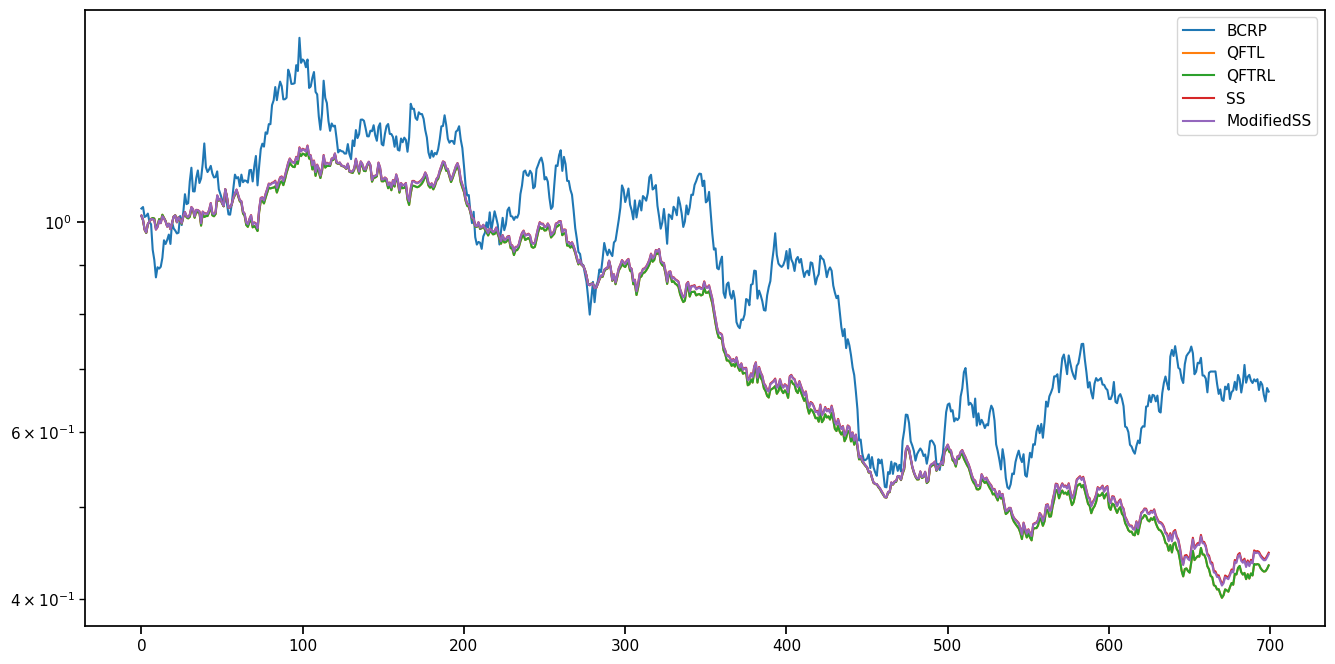

In [30]:
#cмотрим как ведут себя стратегии smooth, modified smooth, ftql по отношению к best (в терминах OCO) стратегии
df[["BCRP", "QFTL", "QFTRL","SS", "ModifiedSS"]].plot(logy=True)

<Axes: >

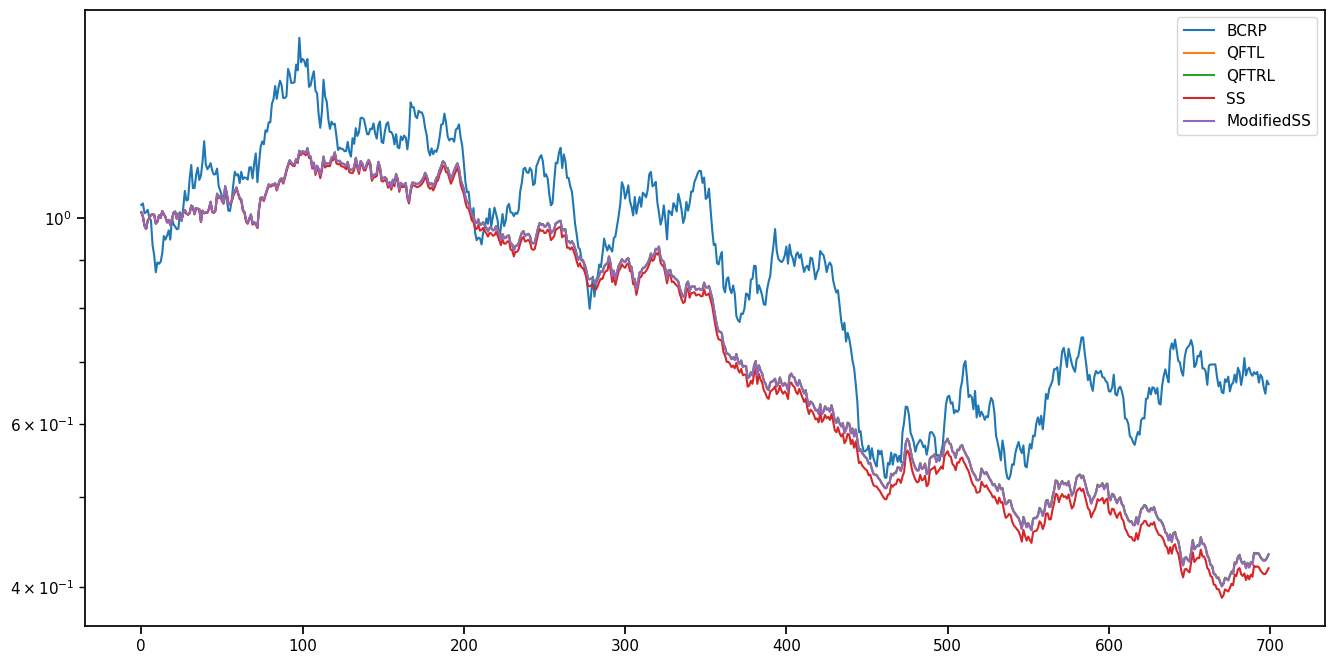

In [ ]:
#cмотрим как ведут себя стратегии smooth, modified smooth, ftql по отношению к best (в терминах OCO) стратегии
df[["BCRP", "QFTL", "QFTRL","SS", "ModifiedSS"]].plot(logy=True)

<Axes: >

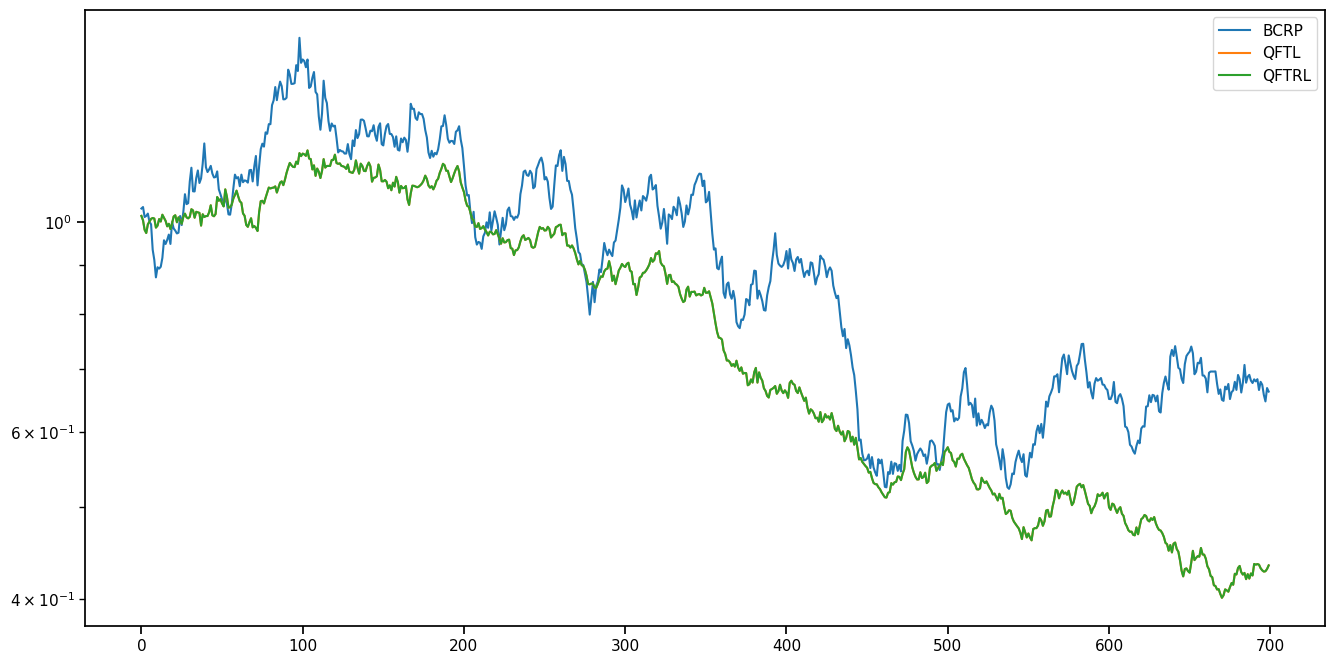

In [31]:
df[["BCRP", "QFTL", "QFTRL"]].plot(logy=True)

<Axes: >

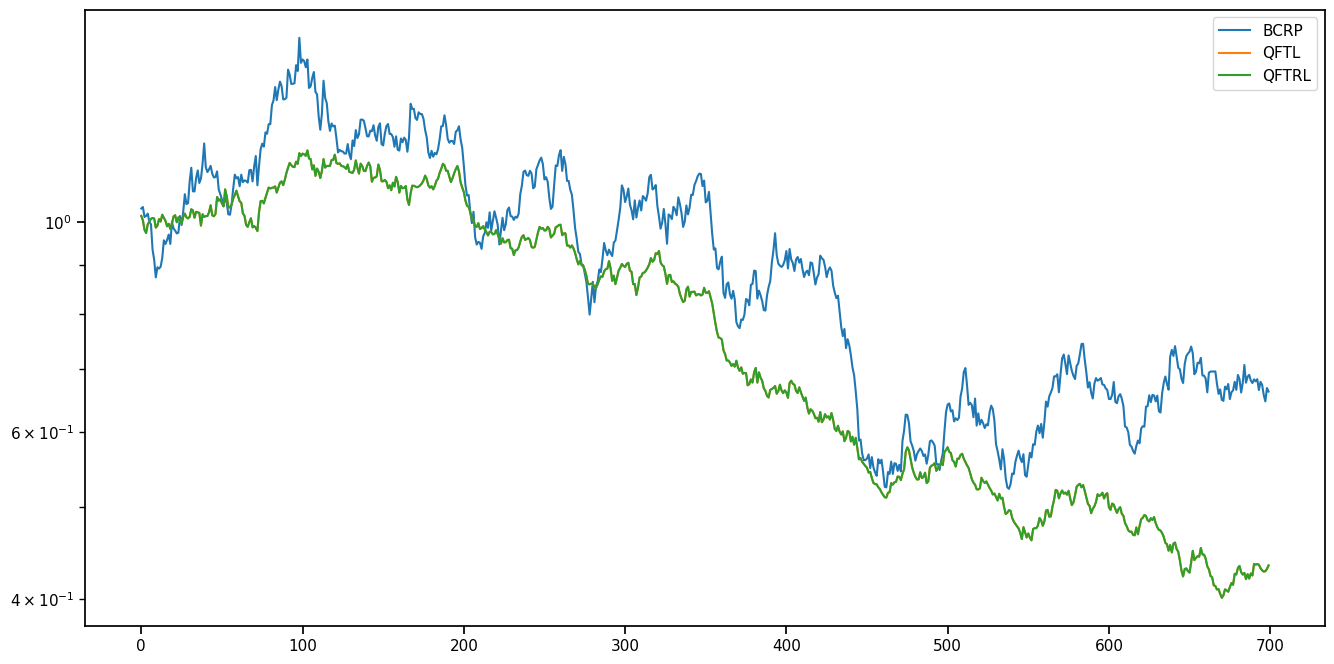

In [ ]:
df[["BCRP", "QFTL", "QFTRL"]].plot(logy=True)